In [1]:
import sys
import os

# Add the path to `database_scripts` folder
sys.path.append(os.path.abspath("../database_scripts"))
import  db_utils as du
import create_tables as ct

conn = ct.create_or_open_database()

df_autos_Zähler = du.fetch_data_df('Messquerschnitt',conn)
df_mess_Autos= du.fetch_data_df('Messdaten_auto',conn)
df_time = du.fetch_data_df('Time_dim',conn)
df_wetter = du.fetch_data_df('Wetter',conn)
#df_merged = df_bezirke.merge(df_autos_Zähler, on='Bezirk', how='left')
df_merged = df_mess_Autos.merge(df_autos_Zähler, on='MQ_KURZNAME', how='left')
df_merged = df_merged.merge(df_time, left_on='Time', right_on='TimeID', how='left')
df_merged = df_merged.merge(df_wetter, left_on=['Date','TimeID','Bezirk'], right_on =['Date','TimeID','Bezirk'],how='left')


Establish SQLite connection.


In [2]:
df_merged.head()

,MQ_KURZNAME,Date,Time,q_pkw_mq_hr,Bezirk,INBETRIEBNAHME,TimeID,time_of_the_day,time,temperature_2m (°C),relative_humidity_2m (%),rain (mm),snowfall (cm),cloud_cover (%)
0,TE004,01.02.2022,5,97,Steglitz-Zehlendorf,2003-02-18 00:00:00,5,morgens,2022-02-01 05:00:00,1.3,91.0,0.0,0.00,100.0
1,TE004,01.02.2022,6,158,Steglitz-Zehlendorf,2003-02-18 00:00:00,6,morgens,2022-02-01 06:00:00,0.9,93.0,0.0,0.00,100.0
2,TE004,01.02.2022,7,262,Steglitz-Zehlendorf,2003-02-18 00:00:00,7,morgens,2022-02-01 07:00:00,1.1,94.0,0.1,0.21,100.0
3,TE004,01.02.2022,8,363,Steglitz-Zehlendorf,2003-02-18 00:00:00,8,morgens,2022-02-01 08:00:00,1.7,91.0,0.0,0.00,100.0
4,TE004,01.02.2022,9,440,Steglitz-Zehlendorf,2003-02-18 00:00:00,9,morgens,2022-02-01 09:00:00,1.9,90.0,0.1,0.00,100.0


In [3]:
df_merged.drop(['TimeID','INBETRIEBNAHME','time'], axis= 1, inplace = True)


In [4]:
df_merged.columns

Index(['MQ_KURZNAME', 'Date', 'Time', 'q_pkw_mq_hr', 'Bezirk',
       'time_of_the_day', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'rain (mm)', 'snowfall (cm)', 'cloud_cover (%)'],
      dtype='object')

In [5]:
columns_to_aggregate = [
    'q_pkw_mq_hr', 
    'temperature_2m (°C)', 
    'relative_humidity_2m (%)', 
    'rain (mm)', 
    'snowfall (cm)', 
    'cloud_cover (%)'
]

aggregated_df = df_merged.groupby(['Bezirk', 'Date', 'Time'])[columns_to_aggregate].mean().reset_index()

aggregated_df

,Bezirk,Date,Time,q_pkw_mq_hr,temperature_2m (°C),relative_humidity_2m (%),rain (mm),snowfall (cm),cloud_cover (%)
0,Charlottenburg-Wilmersdorf,01.01.2018,0,122.628571,11.2,71.0,0.0,0.0,57.0
1,Charlottenburg-Wilmersdorf,01.01.2018,1,267.428571,11.3,69.0,0.0,0.0,73.0
2,Charlottenburg-Wilmersdorf,01.01.2018,2,255.485714,11.7,64.0,0.0,0.0,90.0
3,Charlottenburg-Wilmersdorf,01.01.2018,3,194.857143,11.9,62.0,0.0,0.0,92.0
4,Charlottenburg-Wilmersdorf,01.01.2018,4,152.228571,11.7,63.0,0.0,0.0,92.0
...,...,...,...,...,...,...,...,...,...
622328,Treptow-Köpenick,31.12.2023,19,150.857143,6.6,79.0,0.1,0.0,100.0
622329,Treptow-Köpenick,31.12.2023,20,101.000000,6.3,79.0,0.0,0.0,100.0
622330,Treptow-Köpenick,31.12.2023,21,92.142857,6.6,80.0,0.0,0.0,100.0
622331,Treptow-Köpenick,31.12.2023,22,77.142857,6.3,83.0,0.0,0.0,96.0


In [6]:
bezirk_map =  {
     "Mitte":1, "Friedrichshain-Kreuzberg" :2, "Pankow":3, "Charlottenburg-Wilmersdorf":4, "Spandau": 5 , "Steglitz-Zehlendorf":6, "Tempelhof-Schöneberg":7, "Neukölln":8,
                "Treptow-Köpenick":9, "Marzahn-Hellersdorf":10, "Lichtenberg":11,  "Reinickendorf":12
                }    

aggregated_df['Bezirk'] = aggregated_df['Bezirk'].map(bezirk_map)   


In [7]:
aggregated_df.head()

,Bezirk,Date,Time,q_pkw_mq_hr,temperature_2m (°C),relative_humidity_2m (%),rain (mm),snowfall (cm),cloud_cover (%)
0,4,01.01.2018,0,122.628571,11.2,71.0,0.0,0.0,57.0
1,4,01.01.2018,1,267.428571,11.3,69.0,0.0,0.0,73.0
2,4,01.01.2018,2,255.485714,11.7,64.0,0.0,0.0,90.0
3,4,01.01.2018,3,194.857143,11.9,62.0,0.0,0.0,92.0
4,4,01.01.2018,4,152.228571,11.7,63.0,0.0,0.0,92.0


In [8]:
def convert_time_of_the_day(time):
    time_of_the_day = ()
    if time >= 4 and time < 10 :
        time_of_the_day = 1 #(1,'morgens')
    elif time >= 10 and time < 12:
        time_of_the_day = 2  #(2,'vormittags')
    elif time == 12 :
        time_of_the_day = 3 #(3,'mittags')
    elif time > 12 and time < 17:
        time_of_the_day = 4 #(4,'nachmittags')
    elif time > 17 and time <= 22:
        time_of_the_day = 5 #(5,'abends')      
    else:
        time_of_the_day = 6 #(6,'nachts')
    
    return time_of_the_day

aggregated_df['time_of_the_day'] = aggregated_df['Time'].apply(convert_time_of_the_day)
aggregated_df.drop('Time', axis=1, inplace= True)

In [9]:
aggregated_df.head()

,Bezirk,Date,q_pkw_mq_hr,temperature_2m (°C),relative_humidity_2m (%),rain (mm),snowfall (cm),cloud_cover (%),time_of_the_day
0,4,01.01.2018,122.628571,11.2,71.0,0.0,0.0,57.0,6
1,4,01.01.2018,267.428571,11.3,69.0,0.0,0.0,73.0,6
2,4,01.01.2018,255.485714,11.7,64.0,0.0,0.0,90.0,6
3,4,01.01.2018,194.857143,11.9,62.0,0.0,0.0,92.0,6
4,4,01.01.2018,152.228571,11.7,63.0,0.0,0.0,92.0,1


In [10]:
import pandas as pd
import holidays

# Assuming 'aggregated_df' is your DataFrame
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date'], format='%d.%m.%Y', errors='coerce')

# Generate Berlin holidays for the years in the 'Date' column
berlin_holidays = holidays.Germany(years=aggregated_df['Date'].dt.year.unique(), subdiv='BE')

# Convert holidays to a datetime format
berlin_holidays = pd.to_datetime(list(berlin_holidays.keys()))

# Add the 'day_of_the_week' column (0=Monday, 6=Sunday)
aggregated_df['day_of_the_week'] = aggregated_df['Date'].dt.weekday

# Check if each date is a holiday using .isin()
aggregated_df['is_holiday'] = aggregated_df['Date'].isin(berlin_holidays)

# Display the result
aggregated_df.head()


,Bezirk,Date,q_pkw_mq_hr,temperature_2m (°C),relative_humidity_2m (%),rain (mm),snowfall (cm),cloud_cover (%),time_of_the_day,day_of_the_week,is_holiday
0,4,2018-01-01,122.628571,11.2,71.0,0.0,0.0,57.0,6,0,True
1,4,2018-01-01,267.428571,11.3,69.0,0.0,0.0,73.0,6,0,True
2,4,2018-01-01,255.485714,11.7,64.0,0.0,0.0,90.0,6,0,True
3,4,2018-01-01,194.857143,11.9,62.0,0.0,0.0,92.0,6,0,True
4,4,2018-01-01,152.228571,11.7,63.0,0.0,0.0,92.0,1,0,True


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

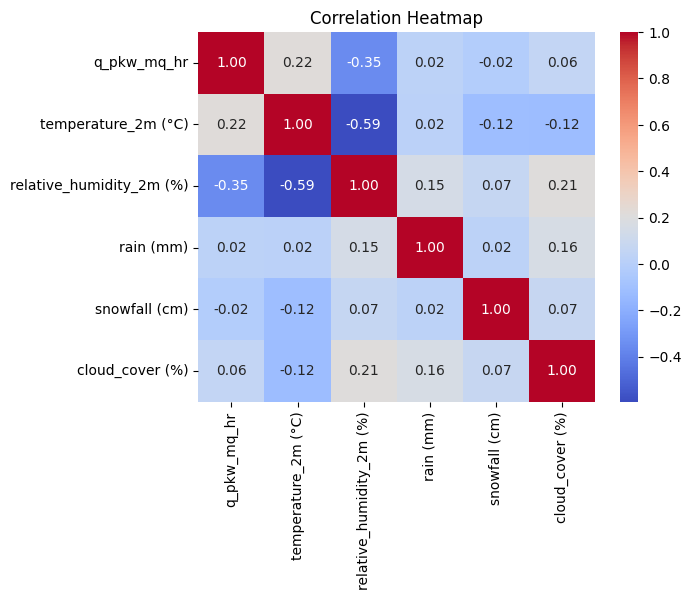

In [12]:

# Select numerical columns
numerical_columns = ['q_pkw_mq_hr', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 
                     'rain (mm)', 'snowfall (cm)', 'cloud_cover (%)']

# Calculate correlation matrix
corr_matrix = aggregated_df[numerical_columns].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


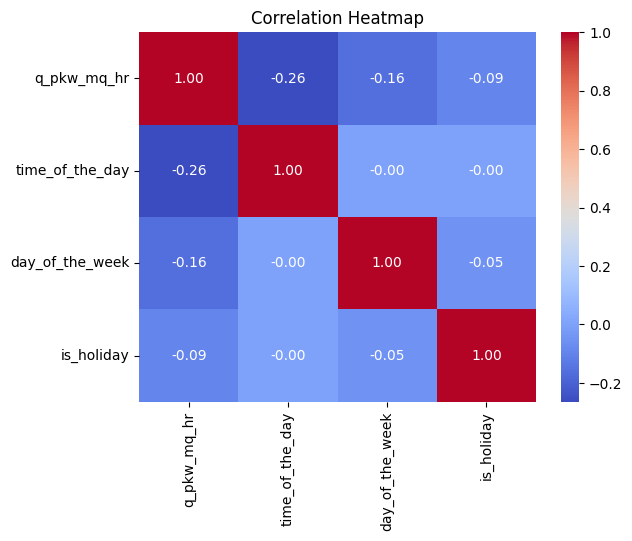

In [13]:

# Select numerical columns
numerical_columns = ['q_pkw_mq_hr',  'time_of_the_day', 'day_of_the_week', 'is_holiday']

# Calculate correlation matrix
corr_matrix = aggregated_df[numerical_columns].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


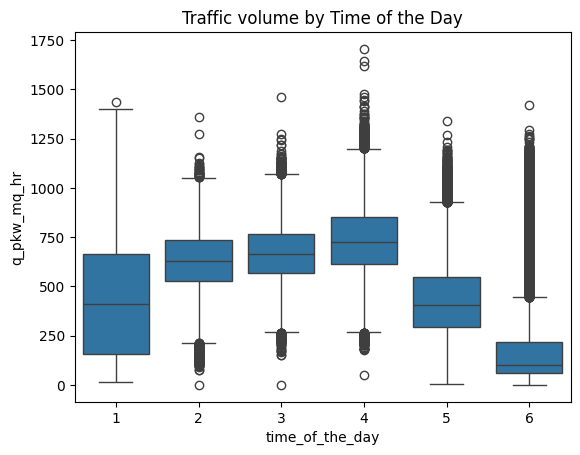

In [14]:
sns.boxplot(x='time_of_the_day', y='q_pkw_mq_hr', data=aggregated_df)
plt.title('Traffic volume by Time of the Day')
plt.show()

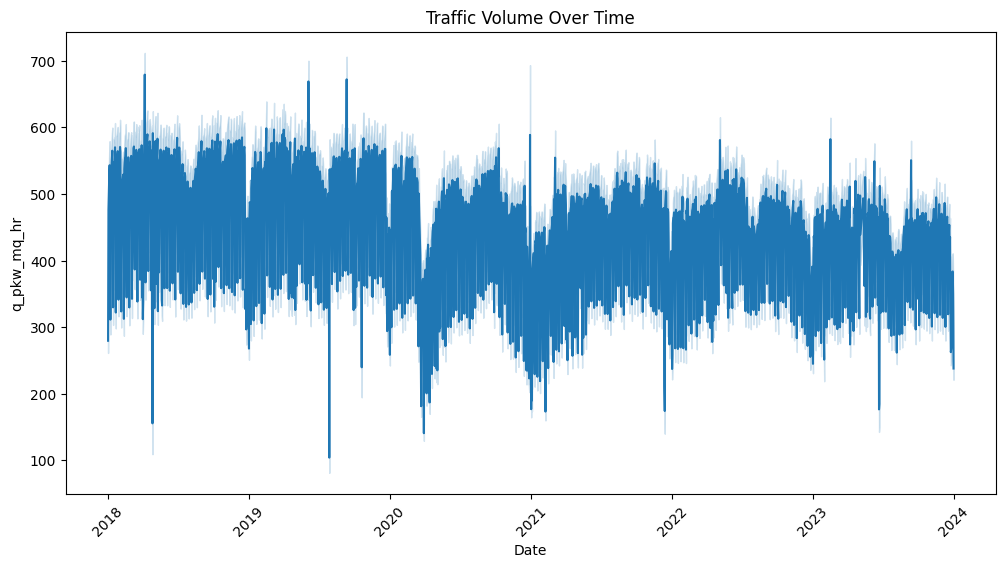

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='q_pkw_mq_hr', data=aggregated_df)
plt.title('Traffic Volume Over Time')
plt.xticks(rotation=45)
plt.show()



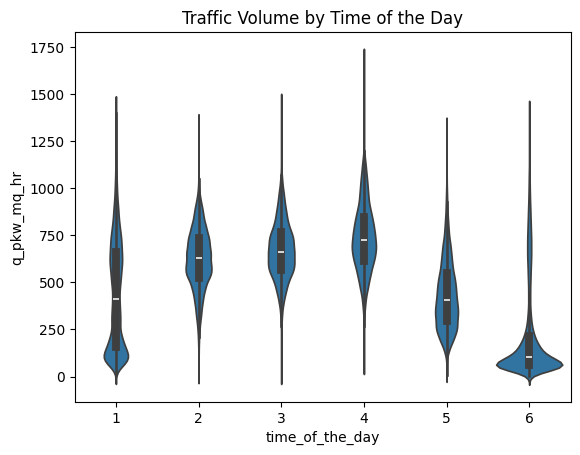

In [16]:
sns.violinplot(x='time_of_the_day', y='q_pkw_mq_hr', data=aggregated_df)
plt.title('Traffic Volume by Time of the Day')
plt.show()

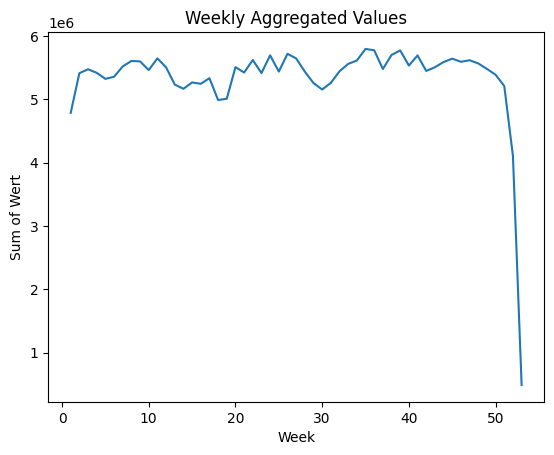

In [17]:

# Assuming df_merged['Date'] is already in datetime format or needs conversion
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date'], format='%d.%m.%Y')

# Extract calendar week from 'Date' column
aggregated_df['week'] = aggregated_df['Date'].dt.isocalendar().week

# Aggregate the 'Wert' column by week
weekly_df = aggregated_df.groupby('week').agg({'q_pkw_mq_hr': 'sum'}).reset_index()

# Plot the aggregated values by week
plt.plot(weekly_df['week'], weekly_df['q_pkw_mq_hr'])

plt.xlabel('Week')
plt.ylabel('Sum of Wert')

plt.title('Weekly Aggregated Values')
plt.show()


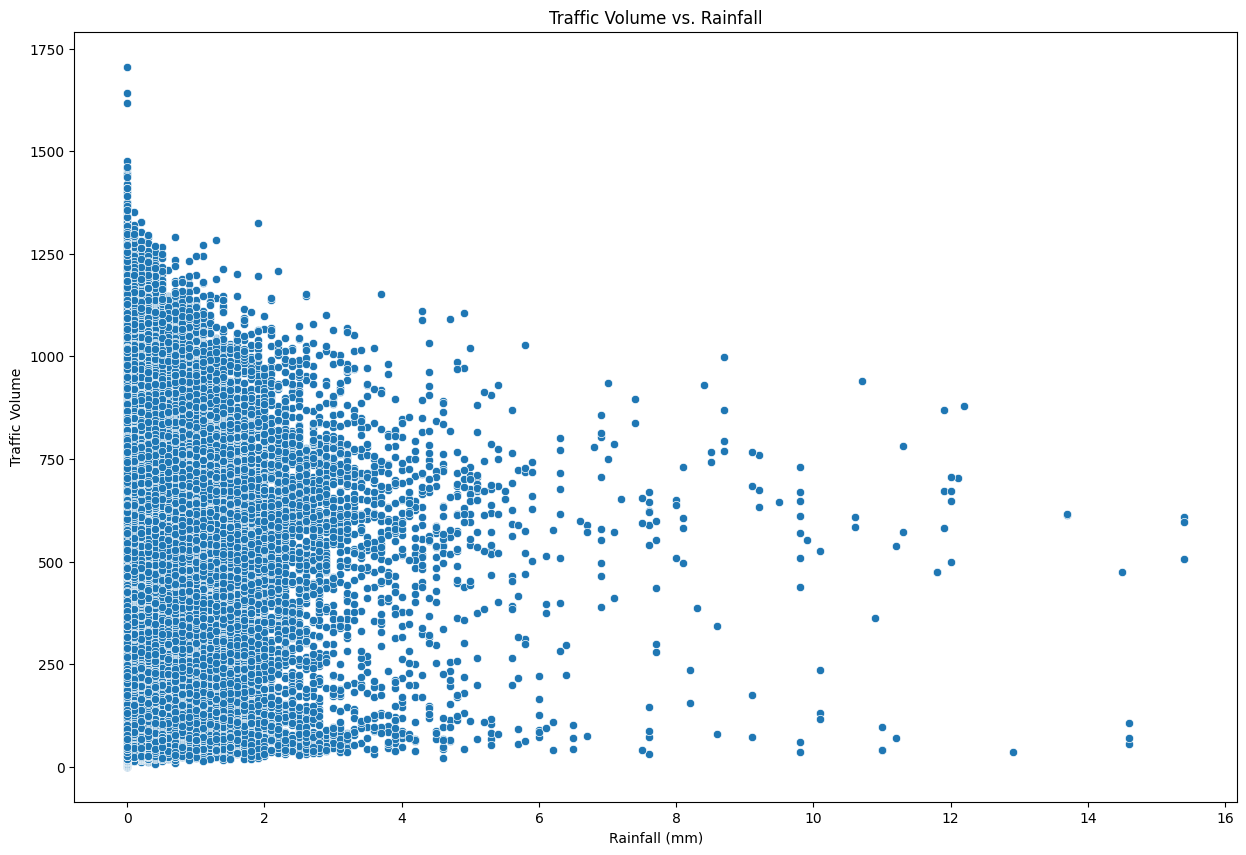

In [18]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='rain (mm)', y='q_pkw_mq_hr', data=aggregated_df)
plt.title('Traffic Volume vs. Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Traffic Volume')
plt.show()


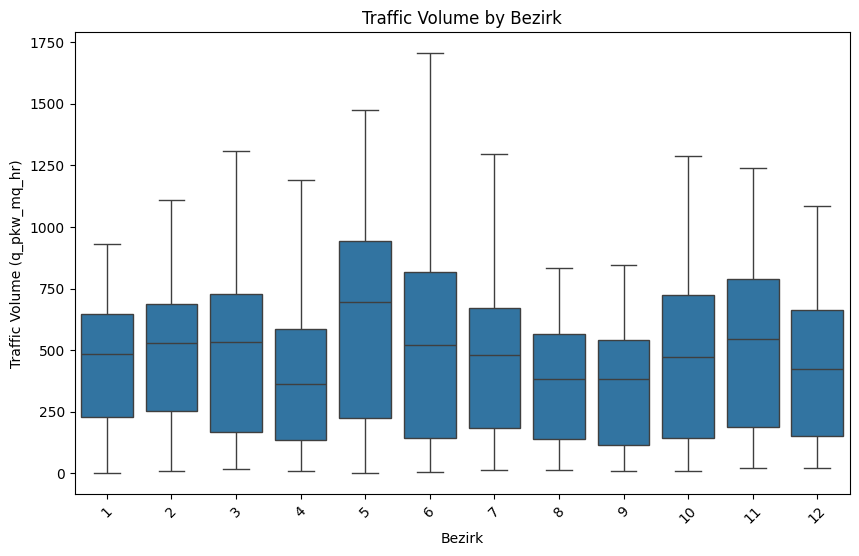

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to show traffic volume distribution across Bezirk
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bezirk', y='q_pkw_mq_hr', data=aggregated_df)
plt.title('Traffic Volume by Bezirk')
plt.xlabel('Bezirk')
plt.ylabel('Traffic Volume (q_pkw_mq_hr)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


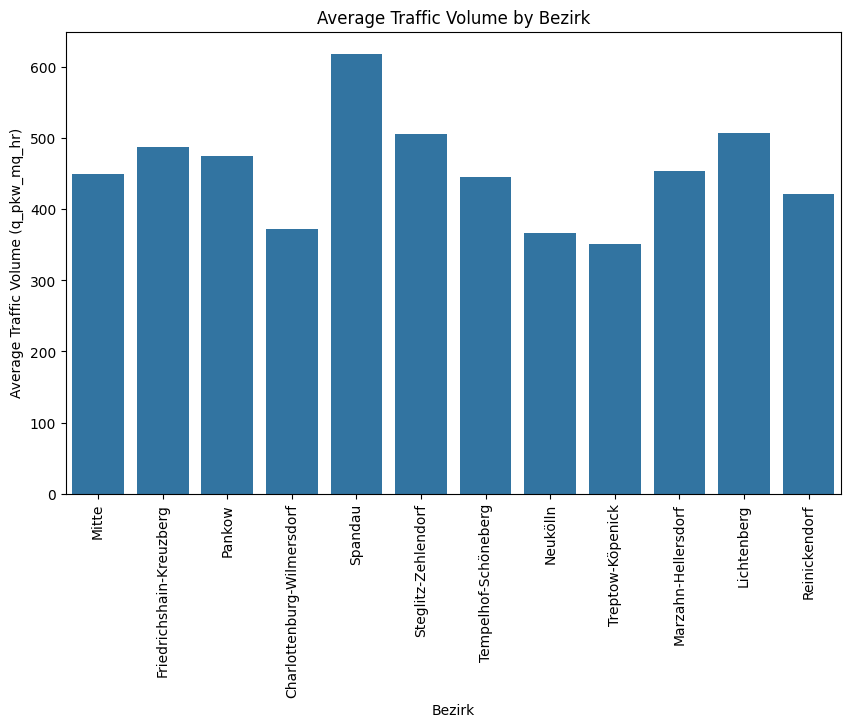

In [20]:
# Calculate the average traffic volume for each Bezirk
avg_traffic_by_bezirk = aggregated_df.groupby('Bezirk')['q_pkw_mq_hr'].mean().reset_index()

# Create a bar plot for average traffic volume per Bezirk
plt.figure(figsize=(10, 6))
sns.barplot(x='Bezirk', y='q_pkw_mq_hr', data=avg_traffic_by_bezirk)
plt.title('Average Traffic Volume by Bezirk')
plt.xlabel('Bezirk')
plt.ylabel('Average Traffic Volume (q_pkw_mq_hr)')
plt.xticks(ticks=range(12), labels=[name for name in bezirk_map.keys()], rotation=90)
plt.show()


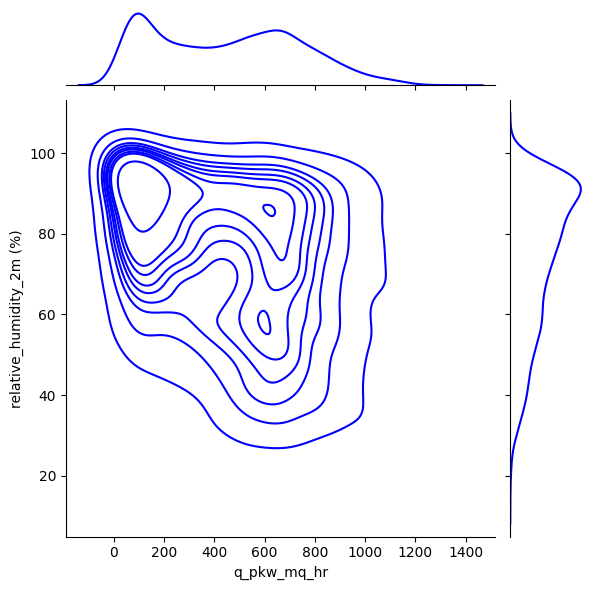

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = aggregated_df[['q_pkw_mq_hr', 'relative_humidity_2m (%)']]

# Sample a smaller subset of the data (e.g., 5000 points)
sampled_data = data.sample(n=5000, random_state=42)

# Create the jointplot
sns.jointplot(x='q_pkw_mq_hr', y='relative_humidity_2m (%)', data=sampled_data, kind='kde', color='blue')
plt.show()


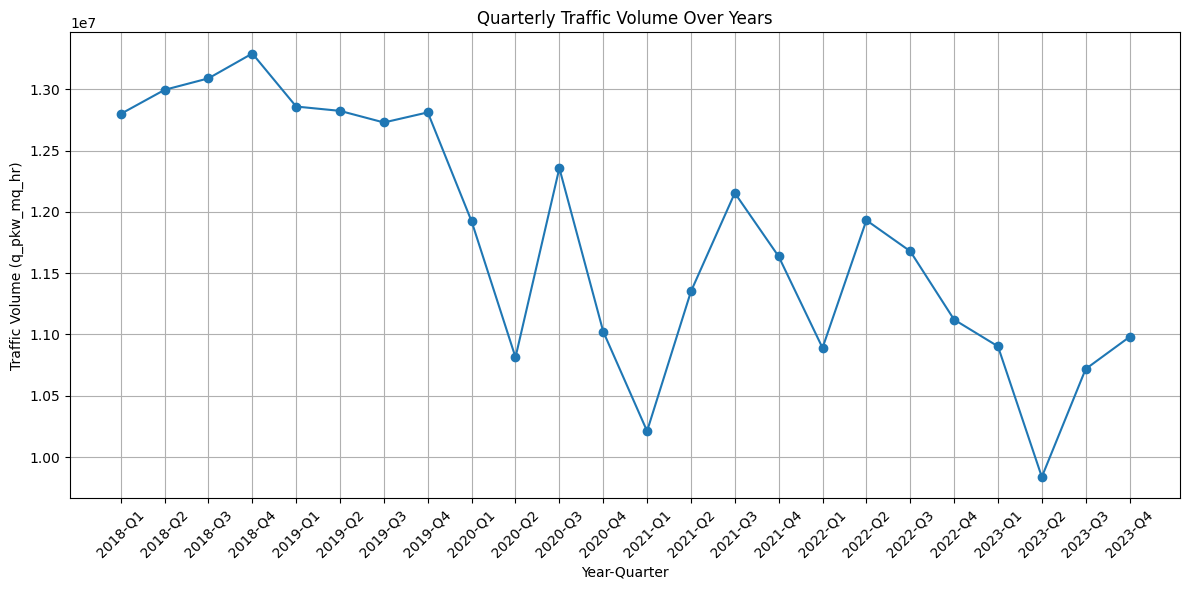

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Date' is in datetime format
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date'], format='%d.%m.%Y')

# Add 'year' and 'quarter' columns
aggregated_df['year'] = aggregated_df['Date'].dt.year
aggregated_df['quarter'] = aggregated_df['Date'].dt.quarter

# Group by year and quarter and sum 'q_pkw_mq_hr'
quarterly_traffic = (
    aggregated_df.groupby(['year', 'quarter'])['q_pkw_mq_hr']
    .sum()
    .reset_index()
)

# Combine year and quarter into a single column for x-axis labels
quarterly_traffic['year_quarter'] = quarterly_traffic['year'].astype(str) + '-Q' + quarterly_traffic['quarter'].astype(str)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(quarterly_traffic['year_quarter'], quarterly_traffic['q_pkw_mq_hr'], marker='o')

plt.xlabel('Year-Quarter')
plt.ylabel('Traffic Volume (q_pkw_mq_hr)')
plt.title('Quarterly Traffic Volume Over Years')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

plt.show()


In [23]:
from sklearn.model_selection import train_test_split

from sklearn import  metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

import numpy as np

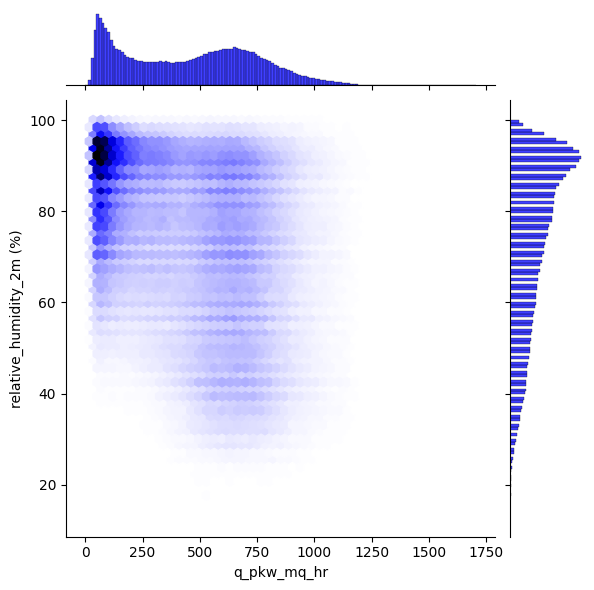

In [25]:
sns.jointplot(x='q_pkw_mq_hr', y='relative_humidity_2m (%)', data=aggregated_df, kind='hex', color='blue')
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Bezirk', y='q_pkw_mq_hr',  data=aggregated_df,hue='time_of_the_day')
plt.title('Number of User Pro Region')
plt.xlabel('Bezirk')
plt.xticks(rotation=90)
plt.ylabel('Number of Users')
plt.show()

In [ ]:
# Pivot table: rows = day, columns = hour, values = mean users
pivot = aggregated_df.pivot_table(values='q_pkw_mq_hr', index='day_of_the_week', columns='Time', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt=".0f")
plt.title('Average/Density Users by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


In [26]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ensure 'Date' is in datetime format
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Date'], format='%d.%m.%Y')

# Convert 'Date' to a numerical format (e.g., ordinal numbers)
aggregated_df['Date_numeric'] = aggregated_df['Date'].map(pd.Timestamp.toordinal)

# Select only numeric columns for features
numeric_columns = aggregated_df.select_dtypes(include=['number']).columns
X = aggregated_df[numeric_columns].drop(['q_pkw_mq_hr'], axis=1)  # Features (drop target variable)
y = aggregated_df['q_pkw_mq_hr']  # Target variable

# Apply StandardScaler only to numeric features
#Normalisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply scaling on features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=101)

# Verify the results
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (416963, 12)
Shape of X_test: (205370, 12)


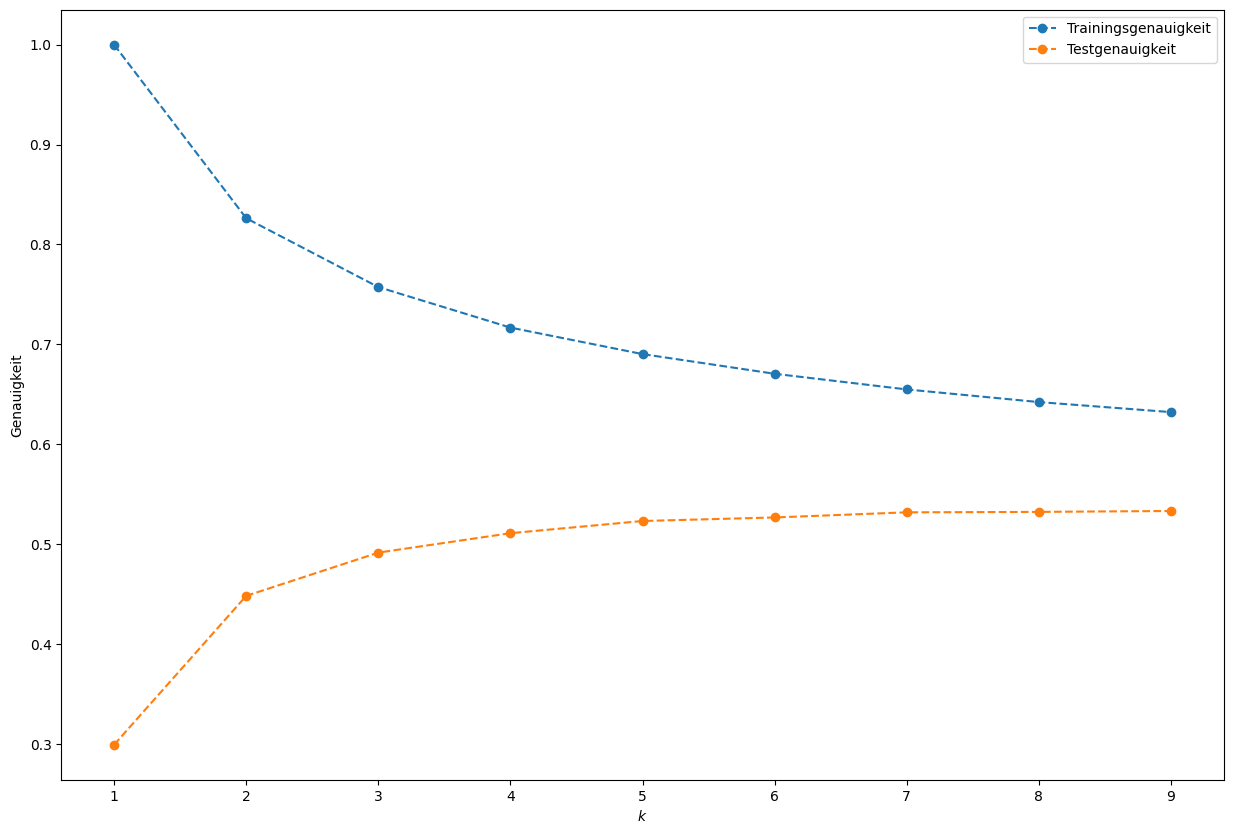

In [27]:

from sklearn.neighbors import KNeighborsRegressor

sample_fraction = 0.1  # Use 10% of the data
X_train_sample = X_train[:int(sample_fraction * len(X_train))]
y_train_sample = y_train[:int(sample_fraction * len(y_train))]
X_test_sample = X_test[:int(sample_fraction * len(X_test))]
y_test_sample = y_test[:int(sample_fraction * len(y_test))]
training_accuracy = []
test_accuracy = []
k_range = range(1, 10)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_sample, y_train_sample)
    training_accuracy.append(knn.score(X_train_sample, y_train_sample))
    test_accuracy.append(knn.score(X_test_sample, y_test_sample))

plt.figure(figsize=[15, 10])
plt.ylabel("Genauigkeit")
plt.xlabel(r"$k$")
plt.plot(k_range, training_accuracy, linestyle="--", marker='o', label="Trainingsgenauigkeit")
plt.plot(k_range, test_accuracy, linestyle="--", marker='o', label="Testgenauigkeit")
plt.legend()
plt.show()



In [28]:
knn = KNeighborsRegressor(n_neighbors =5)  
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
pred

array([393.55111111, 159.75910364, 415.7145641 , ..., 710.88      ,
       306.13890506, 147.64388278])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predictions
pred = knn.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")




In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.scatter(y_test, pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

# Distribution of prediction errors
errors = y_test - pred
plt.hist(errors, bins=50, alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


In [ ]:
#using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Reduce to 5 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    training_accuracy.append(knn.score(X_train_pca, y_train))
    test_accuracy.append(knn.score(X_test_pca, y_test))


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

training_accuracy = []
test_accuracy = []
error_rate = []

k_range = range(1, 10)  # k läuft nun von 1 bis 10.

for k in k_range:
    
    # Model trainieren
    knn = KNeighborsRegressor(n_neighbors = k)  
    knn.fit(X_train, y_train)
    
    # Genauigkeit Trainingsdaten
    training_accuracy.append(knn.score(X_train, y_train))
    
    # Genauigkeit Testdaten
    test_accuracy.append(knn.score(X_test, y_test))


    
plt.figure(figsize=[15,10])
plt.ylabel("Genauigkeit")
plt.xlabel(r"$k$")

plt.plot(k_range, training_accuracy, linestyle="--", marker='o', label="Trainingsgenauigkeit")
plt.plot(k_range, test_accuracy, linestyle="--", marker='o', label="Testgenauigkeit")

plt.legend()